In [171]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('cleanup.R')

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [172]:
players_data <- read_csv("data/players.csv")
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [173]:
sessions_data <- read_csv("data/sessions.csv")
sessions_data

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


I would like to investigate whether a player subscribing to a gaming newsletter may be predicted by play time and age.

We can first observe the trend through graphs.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


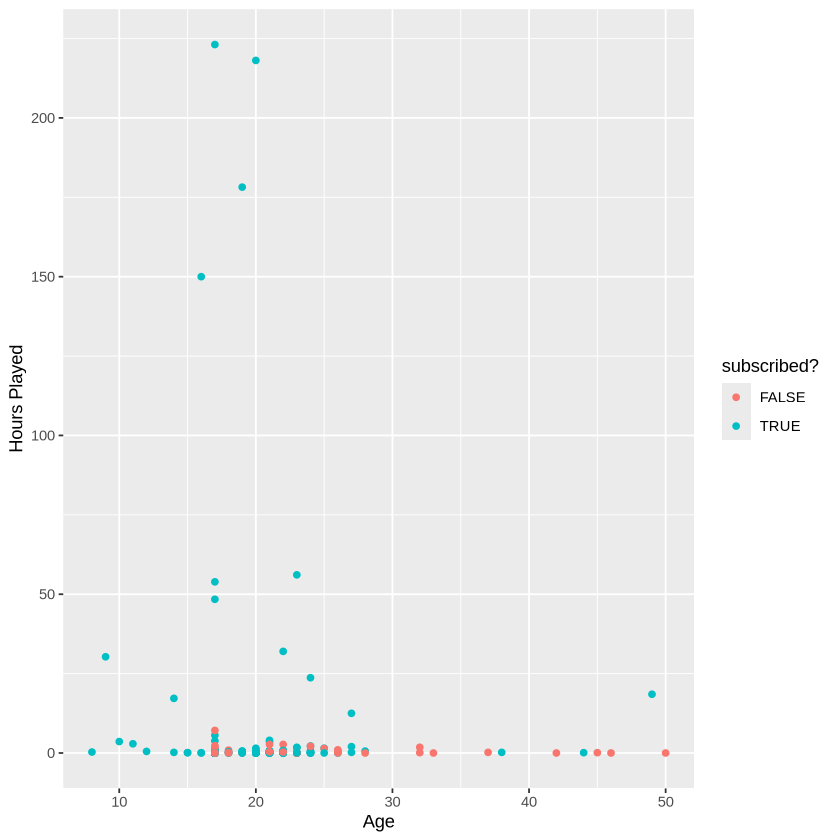

In [174]:
time_age_plot <- players_data |>
                ggplot(aes(x = Age, y = played_hours)) +
                geom_point(aes(color = subscribe)) +
                labs(x = "Age", y = "Hours Played", color = "subscribed?")
time_age_plot

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


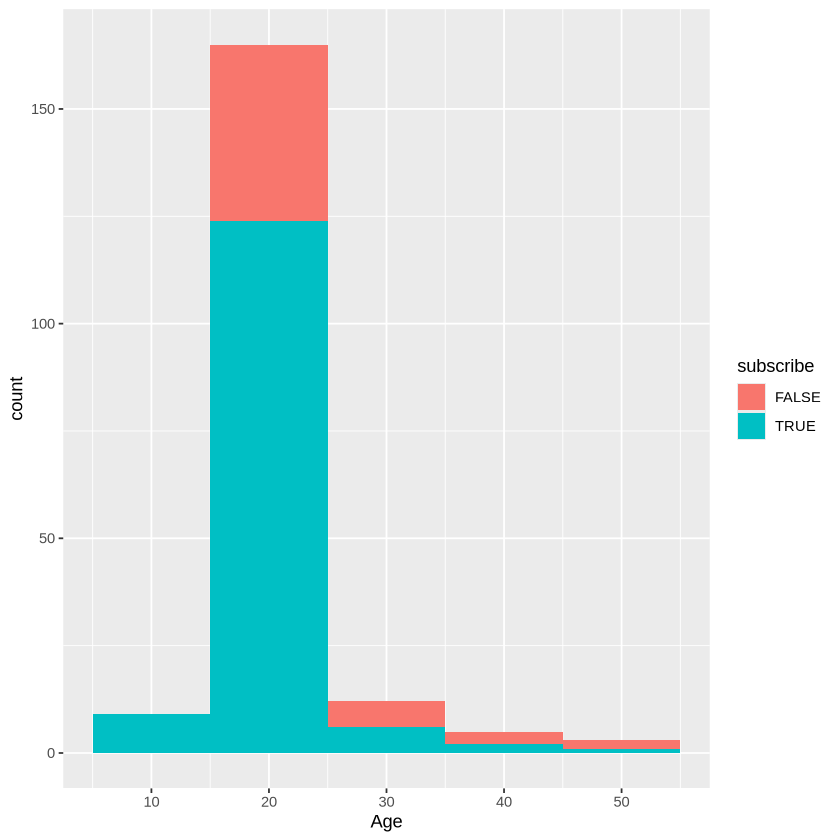

In [175]:
age_histogram <- ggplot(players_data, aes(x = Age)) +
                geom_histogram(binwidth = 10, aes(fill = subscribe))
age_histogram

In [176]:
avg_time_sub <- players_data |>
                group_by(subscribe) |>
                summarize(avg_time_played_hrs = mean(played_hours, na.rm = TRUE))
avg_time_sub

subscribe,avg_time_played_hrs
<lgl>,<dbl>
FALSE,0.5019231
TRUE,7.7756944


In [177]:
experience_sub <- players_data |>
                group_by(experience, subscribe) |>
                summarize(count = n()) |>
                mutate(total_num = nrow(players_data)) |>
                mutate(percentage = count / total_num) |>
                select(experience, subscribe, percentage)
experience_sub

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


experience,subscribe,percentage
<chr>,<lgl>,<dbl>
Amateur,FALSE,0.09183673
Amateur,TRUE,0.22959184
Beginner,FALSE,0.04081633
⋮,⋮,⋮
Regular,TRUE,0.14795918
Veteran,FALSE,0.07653061
Veteran,TRUE,0.16836735


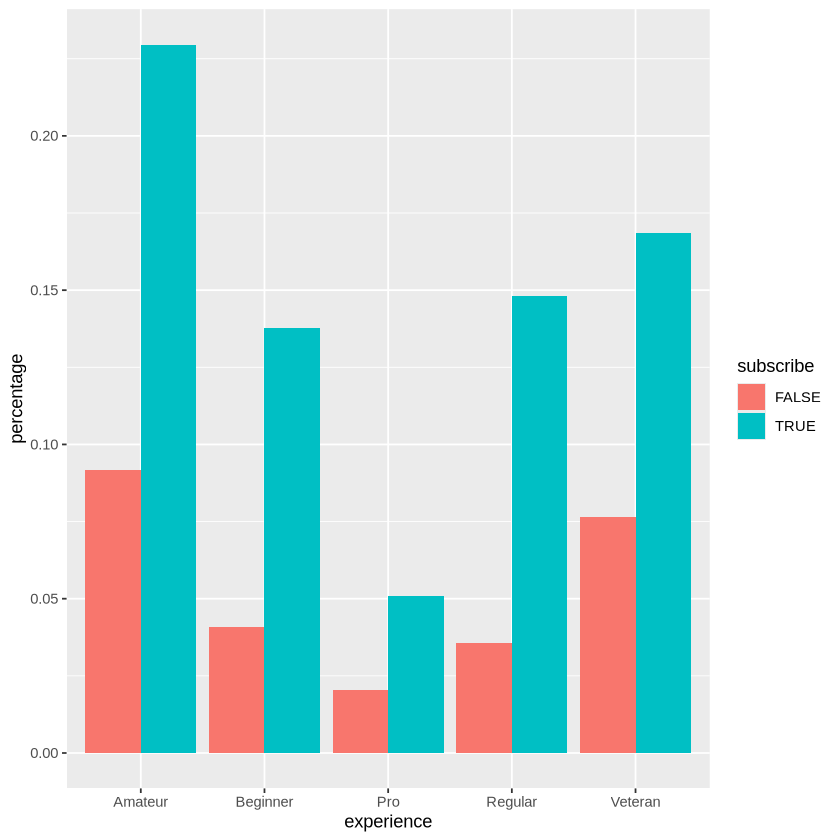

In [178]:
experience_sub_graph <- ggplot(experience_sub, aes(x = experience, y = percentage)) +
                        geom_bar(stat = "identity", position = "dodge", aes(fill = subscribe))
experience_sub_graph

In [179]:
subscribe_count = players_data |>
                group_by(subscribe) |>
                summarize(count = n())
subscribe_count

subscribe,count
<lgl>,<int>
FALSE,52
TRUE,144


In [180]:
age_sub <- players_data |>
        group_by(gender, subscribe) |>
        summarize(count = n()) |>
        arrange(desc(count)) |>
        mutate(total_players = nrow(players_data)) |>
        mutate(percentage = count / total_players) |>
        select(gender, subscribe, percentage)
age_sub

`summarise()` has grouped output by 'gender'. You can override using the
`.groups` argument.


gender,subscribe,percentage
<chr>,<lgl>,<dbl>
Male,TRUE,0.4744898
Male,FALSE,0.1581633
Female,TRUE,0.1479592
⋮,⋮,⋮
Agender,TRUE,0.010204082
Two-Spirited,FALSE,0.010204082
Other,TRUE,0.005102041


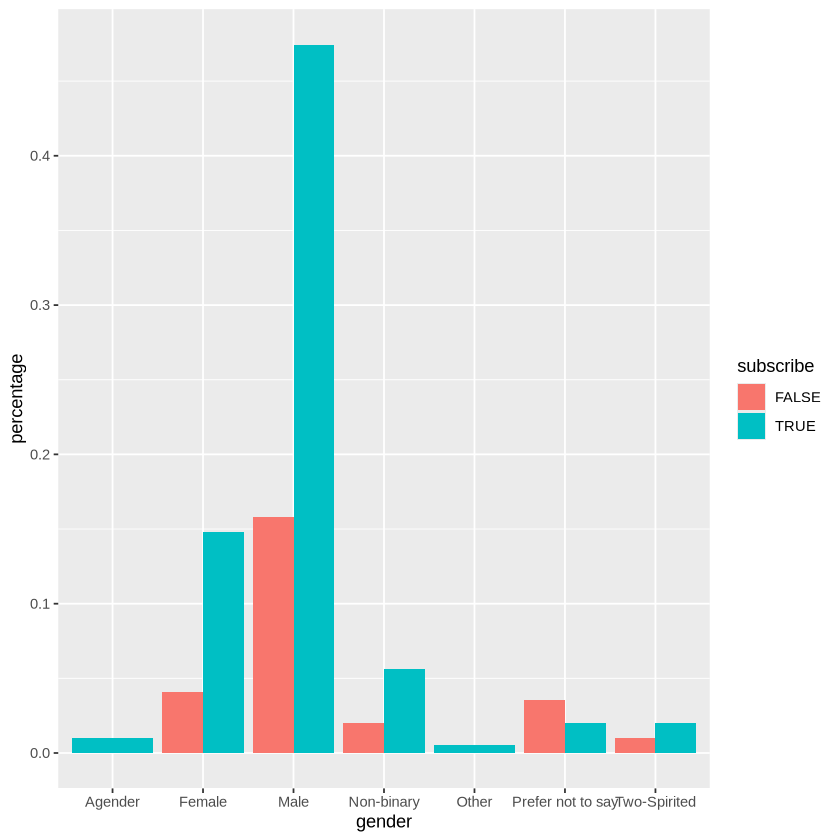

In [181]:
age_sub_plot <- ggplot(age_sub, aes(x = gender, y = percentage)) +
                geom_bar(stat = "identity", position = "dodge", aes(fill = subscribe))
age_sub_plot

# Predictive Model

## Finding the Best K value

In [212]:
players_processed <- players_data |>
                    filter(Age > 15, Age < 25) |>
                    select(experience, subscribe, played_hours, gender) |>
                    mutate(subscribe = as_factor(subscribe)) |>
                    mutate(experience = as_factor(experience)) |>
                    mutate(gender = as_factor(gender))
players_processed

experience,subscribe,played_hours,gender
<fct>,<fct>,<dbl>,<fct>
Veteran,TRUE,3.8,Male
Veteran,FALSE,0.0,Male
Amateur,TRUE,0.7,Female
⋮,⋮,⋮,⋮
Veteran,FALSE,0.3,Male
Amateur,FALSE,0.0,Prefer not to say
Amateur,FALSE,2.3,Male


In [219]:
set.seed(1000)
players_split <- initial_split(players_processed, prop = 0.70, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [220]:
set.seed(2000)
sub_recipe <- recipe(subscribe ~ played_hours + experience + gender, data = players_training) |>
            step_scale(played_hours) |>
            step_center(played_hours)
sub_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
sub_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)
vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

sub_fit <- workflow() |>
        add_recipe(sub_recipe) |>
        add_model(sub_spec) |>
        tune_grid(resamples = sub_vfold, grid = vals) |>
        collect_metrics() |>
        filter(.metric == "accuracy") |>
        filter(mean == max(mean))
sub_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.7351779,5,0.022069,Preprocessor1_Model09
10,accuracy,binary,0.7351779,5,0.022069,Preprocessor1_Model10


In [225]:
set.seed(3000)
tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
            set_engine("kknn") |>
            set_mode("classification")
tuned_fit <- workflow() |>
            add_recipe(sub_recipe) |>
            add_model(tuned_spec) |>
            fit(players_training)

In [226]:
set.seed(4000)
players_predictions <- predict(tuned_fit, players_testing) |>
                    bind_cols(players_testing)
players_predictions
players_metrics <- players_predictions |>
                metrics(truth = subscribe, estimate = .pred_class)
players_metrics
players_conf_mat <- players_predictions |>
                    conf_mat(truth = subscribe, estimate = .pred_class)
players_conf_mat

.pred_class,experience,subscribe,played_hours,gender
<fct>,<fct>,<fct>,<dbl>,<fct>
TRUE,Veteran,FALSE,0.0,Male
TRUE,Amateur,TRUE,0.7,Female
TRUE,Regular,TRUE,0.0,Female
⋮,⋮,⋮,⋮,⋮
TRUE,Beginner,TRUE,0.0,Female
TRUE,Veteran,FALSE,0.3,Male
TRUE,Amateur,FALSE,2.3,Male


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7551020
kap,binary,0.1453488


          Truth
Prediction FALSE TRUE
     FALSE     2    2
     TRUE     10   35

$Recall = 35 / 37 = 0.95$

$Precision = 35 / 45 = 0.78$